In [5]:
from time import time
import numpy as np
from matplotlib import pyplot as plt

# Qiskit
from qiskit import IBMQ, transpile

# Local modules
from utilities import startup, check_provider
from graphstate import GraphState, calc_negativities, plot_negativities_multi, calc_n_mean, plot_cxerr_corr

provider = startup(hub='ibm-q-melbourne', group='unimelb', project='hub')

Account enabled
Provider: ibm-q-melbourne-unimelb-hub


In [1]:
from time import time
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
#from qiskit.providers.ibmq.managed import IBMQJobManager

from utilities import startup, bit_str_list, run_cal
from graphstate import GraphState, calc_negativities, plot_negativities_multi, calc_n_mean, plot_cxerr_corr

hub = "ibm-q-melbourne"
group = "unimelb"
project = "hub"
backend_name = 'ibm_sherbrooke'
hgp = f"{hub}/{group}/{project}"

provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)
#provider = startup()

In [2]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from graphstate import GraphState, calc_negativities, plot_negativities_multi, calc_n_mean, plot_cxerr_corr

#qiskit
from qiskit import transpile, execute, QuantumCircuit, ClassicalRegister
from qiskit.circuit.random import random_circuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
from qiskit_ibm_runtime.options import Options
service = QiskitRuntimeService()
backend = service.backend('ibmq_qasm_simulator')
print(backend.name)

ibmq_qasm_simulator


In [5]:
check_provider()

ibmq_qasm_simulator has 0 queud and simulated qubits
ibmq_kolkata has 127 queud and 27 qubits
ibmq_mumbai has 1259 queud and 27 qubits
ibmq_lima has 32 queud and 5 qubits
ibmq_belem has 46 queud and 5 qubits
ibmq_quito has 26 queud and 5 qubits
ibmq_guadalupe has 165 queud and 16 qubits
simulator_statevector has 0 queud and simulated qubits
simulator_mps has 0 queud and simulated qubits
simulator_extended_stabilizer has 0 queud and simulated qubits
simulator_stabilizer has 0 queud and simulated qubits
ibmq_jakarta has 275 queud and 7 qubits
ibmq_manila has 42 queud and 5 qubits
ibm_hanoi has 811 queud and 27 qubits
ibm_lagos has 40 queud and 7 qubits
ibm_nairobi has 609 queud and 7 qubits
ibm_cairo has 257 queud and 27 qubits
ibm_auckland has 172 queud and 27 qubits
ibm_perth has 323 queud and 7 qubits
ibm_washington has 1 queud and 127 qubits
ibm_sherbrooke has 55 queud and 127 qubits
ibm_brisbane has 14 queud and 127 qubits


In [2]:
import networkx as nx

def get_negativity_info(n_list, nmit_list):
    
    n_mean_dict, _ = calc_n_mean(n_list)
    n_mean = np.mean(list(n_mean_dict.values()))
    std = np.std(list(n_mean_dict.values()))

    nmit_mean_dict, _ = calc_n_mean(nmit_list)
    nmit_mean = np.mean(list(nmit_mean_dict.values()))
    std_mit = np.std(list(nmit_mean_dict.values()))
    
    n5 = get_largest_connected(n_mean_dict, threshold=0.025)
    n50 = get_largest_connected(n_mean_dict, threshold=0.25)
    n75 = get_largest_connected(n_mean_dict, threshold=0.75*0.5)
    n90 = get_largest_connected(n_mean_dict, threshold=0.9*0.5)
    
    nmit5 = get_largest_connected(nmit_mean_dict, threshold=0.025)
    nmit50 = get_largest_connected(nmit_mean_dict, threshold=0.25)
    nmit75 = get_largest_connected(nmit_mean_dict, threshold=0.75*0.5)
    nmit90 = get_largest_connected(nmit_mean_dict, threshold=0.9*0.5)
    
    info_dict = {'Mean negativity': n_mean,
                 'std': std,
                'Mean negativity (mit)': nmit_mean,
                 'std (mit)': std_mit,
                'Connected N>5%': len(n5),
                'Connected N>50%': len(n50),
                'Connected N>75%': len(n75),
                'Connected N>90%': len(n90),
                'Connected N>5% (mit)': len(nmit5),
                'Connected N>50% (mit)': len(nmit50),
                'Connected N>75% (mit)': len(nmit75),
                'Connected N>90% (mit)': len(nmit90)}

    return info_dict

def get_largest_connected(n_dict, threshold=0.25):
    
    edges = filter_edges(n_dict, threshold)
    G = nx.Graph()
    G.add_edges_from(edges)
    try:
        largest = max(nx.connected_components(G), key=len)
    except:
        largest = {}
    
    return largest
    
def filter_edges(n_dict, threshold=0.25/2):
    return [key for key, value in n_dict.items() if value >= threshold]

### Negativity Calculation and Plotting

In [2]:
plt.rc('font', size=12.5)

#### ibmq_lima

In [4]:
import csv

backend = provider.get_backend('ibmq_belem')
graphstate = GraphState(backend)

delays_ns = list(range(0,41000,1000))
delays = graphstate.format_delays(delays_ns, unit='ns')
increment = delays[1]-delays[0]

jobs_id = []
jobs_id.append(['jobs','jobs_id'])
#free delay
for t in delays:
    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling=False) #, pulses=4)
    
    job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
    #job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
    jobs_id.append([f'free_delay1-{t}', job1.job_id()])
    #jobs_id.append([f'free_delay2-{t}', job2.job_id()])

#pdd activated
for t in delays:
    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling='hahn_echo') #, pulses=4)
    
    job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
    #job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
    jobs_id.append([f'pdd1-{t}', job1.job_id()])
    #jobs_id[f'pdd2-{t}'] = job2.job_id()

fp = open('jobs_id_belem_hahn_echo_41000ns','w')
writer = csv.writer(fp, delimiter='|')
writer.writerows(jobs_id)
fp.close()

KeyboardInterrupt: 

In [3]:
import csv
jobs_id = {}

fp = open('jobs_id_belem_hahn_echo','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        print(row)
        jobs_id[row[0]] = row[1]
    line_count += 1
fp.close()
print(jobs_id)

['free_delay1-0.0', '63b77bb738d550ad92676575']
['free_delay1-4496.0', '63b77bbdc8b82952c2c25a3c']
['free_delay1-9008.0', '63b77bc4e9c45ac495611f14']
['free_delay1-13504.0', '63b77bc9ccb367e52bd7621d']
['free_delay1-18000.0', '63b77bcfc8b829722bc25a3d']
['free_delay1-22496.0', '63b77bd3a670b3567f9c8c77']
['free_delay1-27008.0', '63b77bd8d23e95013b038300']
['free_delay1-31504.0', '63b77bdc38d5504979676577']
['free_delay1-36000.0', '63b77be0fd03a4edc521923c']
['free_delay1-40496.0', '63b77be4e9c45a4aac611f15']
['free_delay1-45008.0', '63b77bef0f67e7ed25c9f2a3']
['free_delay1-49504.0', '63b77bf30f67e74965c9f2a4']
['free_delay1-54000.0', '63b77bf7fd03a4edcb219240']
['free_delay1-58496.0', '63b77bfbe9c45a740d611f16']
['free_delay1-63008.0', '63b77bff0f67e7c6b0c9f2a5']
['free_delay1-67504.0', '63b77c03a670b3eae39c8c79']
['free_delay1-72000.0', '63b77c07ccb36727acd7621e']
['free_delay1-76496.0', '63b77c0ca670b37ecb9c8c7a']
['free_delay1-81008.0', '63b77c11c8b829c55ac25a3e']
['free_delay1-8550

0.29355185811428514
0.42204900206831564
0.2435544304833596
0.35266450702173835
0.19160694186431515
0.29053875971690635
0.17750617981433192
0.2668064684857301
0.12133772680547045
0.190117505677623
0.04853847046279071
0.09778393918755013
0.013424505593414437
0.04050415851605495
0.0019336084057665717
0.014158850696095572
0.0
0.000663649976300137
0.0
0.0
0.0
0.0
0.0
0.00017212847679430547
0.0016371000441922636
0.00422996739709482
0.0033999554382892123
0.009170527631033704
0.0017879566005125098
0.008491195480448592
0.000853348506369196
0.005373886279265383
0.0013610990404304376
0.005257494513127918
0.0017592662565309694
0.007943325598785977
0.0011306416381844028
0.008237117838060012
0.01044898220901867
0.026698204104394607
0.007126507870145608
0.014502372418468159
0.2910274401671343
0.4195662752472047
0.25877057900025985
0.3753697794490627
0.2301999756453457
0.3408309448437973
0.18877077342933626
0.2807884088331881
0.14423151030177422
0.22161355927453355
0.09688352850872113
0.16100308039144

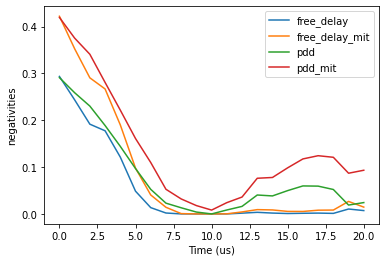

In [4]:
import csv
jobs_id = {}

fp = open('jobs_id_belem_hahn_echo_41000ns','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        jobs_id[row[0]] = row[1]
    line_count += 1
fp.close()

backend = provider.get_backend('ibmq_belem')
graphstate = GraphState(backend)

delays_ns = list(range(0,41000,1000))
delays = graphstate.format_delays(delays_ns, unit='ns')
increment = delays[1]-delays[0]

negativities_free_delay = []
negativities_free_delay_mit = []
negativities_pdd = []
negativities_pdd_mit = []

#free delay negativities
for t in delays:
    job_id1 = jobs_id[f'free_delay1-{t}']
    #job_id2 = jobs_id[f'free_delay2-{t}']
    job1 = backend.retrieve_job(job_id1)
    #job2 = backend.retrieve_job(job_id2)
    
    rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
    #rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
    
    n_list1 = calc_negativities(rho_dict1, mode='mean')
    nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
    #n_list2 = calc_negativities(rho_dict2, mode='max')
    #nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
    n_list = n_list1 #+ n_list2
    nmit_list = nmit_list1 #+ nmit_list2
    
    info = get_negativity_info(n_list, nmit_list)
    print(info['Mean negativity'])
    print(info['Mean negativity (mit)'])
    negativities_free_delay.append(info['Mean negativity'])
    negativities_free_delay_mit.append(info['Mean negativity (mit)'])
    

#pdd negativities
for t in delays:
    job_id1 = jobs_id[f'pdd1-{t}']
    #job_id2 = jobs_id[f'pdd2-{t}']
    job1 = backend.retrieve_job(job_id1)
    #job2 = backend.retrieve_job(job_id2)
    
    rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
    #rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
    
    n_list1 = calc_negativities(rho_dict1, mode='mean')
    nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
    #n_list2 = calc_negativities(rho_dict2, mode='max')
    #nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
    n_list = n_list1 #+ n_list2
    nmit_list = nmit_list1 #+ nmit_list2
    
    info = get_negativity_info(n_list, nmit_list)
    print(info['Mean negativity'])
    print(info['Mean negativity (mit)'])
    negativities_pdd.append(info['Mean negativity'])
    negativities_pdd_mit.append(info['Mean negativity (mit)'])

X = np.array(delays_ns)/1000
plt.plot(X, negativities_free_delay, label='free_delay')
plt.plot(X, negativities_free_delay_mit, label='free_delay_mit')
plt.plot(X, negativities_pdd, label='pdd')
plt.plot(X, negativities_pdd_mit, label='pdd_mit')
plt.xlabel('Time (us)')
plt.ylabel('negativities')
plt.legend()

In [ ]:
time0 = time()
backend = provider.get_backend('ibmq_lima')
job1 = backend.retrieve_job('639a74913c2e3c7b92a51ecd')
job2 = backend.retrieve_job('639a749605888ee79a998915')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

{'Mean negativity': 0.36343288870551954,
 'std': 0.03614586182416435,
 'Mean negativity (mit)': 0.47020018641267863,
 'std (mit)': 0.011086446003699306,
 'Connected N>5%': 5,
 'Connected N>50%': 5,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 5}

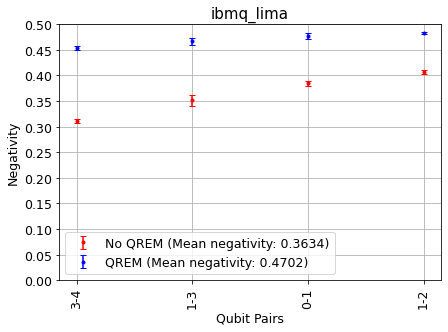

In [15]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_belem

In [5]:
backend = provider.get_backend('ibmq_belem')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_belem (5 qubits)
Job 1 ID: 639a7653fd1c84d95ceb840c
Job 2 ID: 639a76583c2e3c0eb6a51ed4


In [3]:
time0 = time()
backend = provider.get_backend('ibmq_belem')
job1 = backend.retrieve_job('639a7653fd1c84d95ceb840c')
job2 = backend.retrieve_job('639a76583c2e3c0eb6a51ed4')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 15.16 s


{'Mean negativity': 0.3234802055171218,
 'std': 0.015526012500209869,
 'Mean negativity (mit)': 0.444233535820456,
 'std (mit)': 0.006190685084597203,
 'Connected N>5%': 5,
 'Connected N>50%': 5,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 2}

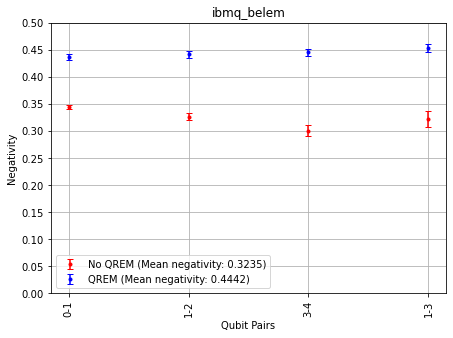

In [4]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
#fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_quito

In [5]:
backend = provider.get_backend('ibmq_quito')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_quito (5 qubits)
Job 1 ID: 62e083cc22b5f5c9d5565888
Job 2 ID: 62e083d1c2d4972bd5e36bec


In [18]:
time0 = time()
backend = provider.get_backend('ibmq_quito')
job1 = backend.retrieve_job('62e083cc22b5f5c9d5565888')
job2 = backend.retrieve_job('62e083d1c2d4972bd5e36bec')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 3.65 s


{'Mean negativity': 0.3005996250992291,
 'std': 0.011843931894246254,
 'Mean negativity (mit)': 0.4855397455673087,
 'std (mit)': 0.009991937296500254,
 'Connected N>5%': 5,
 'Connected N>50%': 5,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 5}

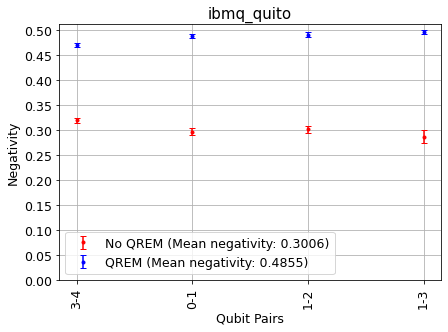

In [19]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_manila

In [15]:
#backend = provider.get_backend('ibmq_manila')
graphstate = GraphState(backend, qubits_to_connect=[1,2])
graphstate.gen_qst_circuits()
graphstate.qst_circuits['batch0']['ZZ'].draw()
#job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
#job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

#print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
#print("Job 1 ID:", job1.job_id())#
#print("Job 2 ID:", job2.job_id())

░       
   q_0: ─────────░───────
        ┌───┐    ░ ┌─┐   
   q_1: ┤ H ├─■──░─┤M├───
        ├───┤ │  ░ └╥┘┌─┐
   q_2: ┤ H ├─■──░──╫─┤M├
        └───┘    ░  ║ └╥┘
   q_3: ─────────░──╫──╫─
                 ░  ║  ║ 
   q_4: ─────────░──╫──╫─
                 ░  ║  ║ 
c800: 2/════════════╩══╩═
                    0  1

In [30]:
from math import pi
a = np.linspace(0,pi,10)
print(a)


[0.         0.34906585 0.6981317  1.04719755 1.3962634  1.74532925
 2.0943951  2.44346095 2.7925268  3.14159265]


True

In [20]:
time0 = time()
backend = provider.get_backend('ibmq_manila')
job1 = backend.retrieve_job('62debdad9ef0519cc8768fb4')
job2 = backend.retrieve_job('62debdb11813981a54c6cb2a')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 4.93 s


{'Mean negativity': 0.38839167441458045,
 'std': 0.013378899171218215,
 'Mean negativity (mit)': 0.48689800222442786,
 'std (mit)': 0.0028244432643853143,
 'Connected N>5%': 5,
 'Connected N>50%': 5,
 'Connected N>75%': 5,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 5}

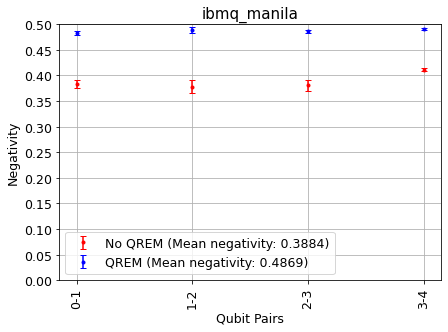

In [21]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_jakarta

In [4]:
backend = provider.get_backend('ibmq_jakarta')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_jakarta (7 qubits)
Job 1 ID: 62e0bea3c2d497582ee36c59
Job 2 ID: 62e0beb28fc0975ff00a868f


In [ ]:
time0 = time()
backend = provider.get_backend('ibmq_jakarta')
job1 = backend.retrieve_job('62e0bea3c2d497582ee36c59')
job2 = backend.retrieve_job('62e0beb28fc0975ff00a868f')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 5.87 s


{'Mean negativity': 0.3028467270047333,
 'std': 0.028960399615682305,
 'Mean negativity (mit)': 0.48189924433819903,
 'std (mit)': 0.007166825807386201,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

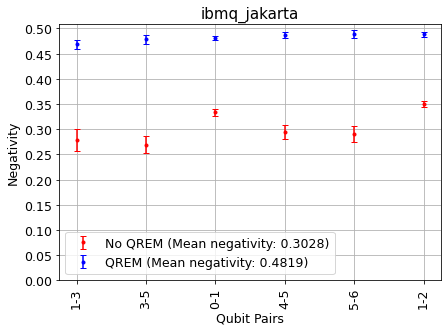

In [ ]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_oslo

In [10]:
backend = provider.get_backend('ibm_oslo')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_oslo (7 qubits)
Job 1 ID: 62e085925593a8ab36192710
Job 2 ID: 62e08599fb9fa11c75a31beb


In [24]:
time0 = time()
backend = provider.get_backend('ibm_oslo')
job1 = backend.retrieve_job('62e085925593a8ab36192710')
job2 = backend.retrieve_job('62e08599fb9fa11c75a31beb')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 6.01 s


{'Mean negativity': 0.402996108004936,
 'std': 0.018986107280654405,
 'Mean negativity (mit)': 0.4882854011274406,
 'std (mit)': 0.00985354920644814,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 6,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

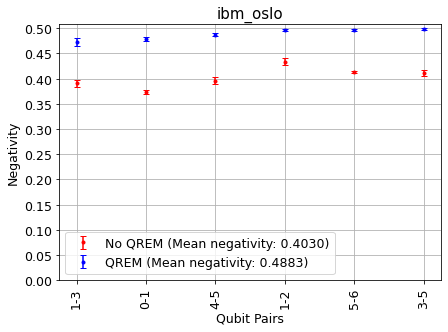

In [25]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_nairobi

In [58]:
backend = provider.get_backend('ibm_nairobi')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_nairobi (7 qubits)
Job 1 ID: 633859475706bc52c04659b4
Job 2 ID: 6338594f5706bca0ab4659b5


In [27]:
time0 = time()
backend = provider.get_backend('ibm_nairobi')
job1 = backend.retrieve_job('633859475706bc52c04659b4')
job2 = backend.retrieve_job('6338594f5706bca0ab4659b5')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 5.85 s


{'Mean negativity': 0.37498304553540945,
 'std': 0.005185117424300301,
 'Mean negativity (mit)': 0.48760564732337247,
 'std (mit)': 0.004256760509462615,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

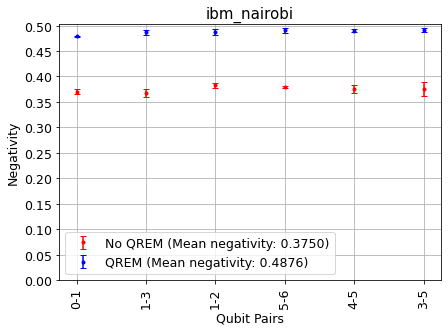

In [28]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_lagos

In [12]:
backend = provider.get_backend('ibm_lagos')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_lagos (7 qubits)
Job 1 ID: 62e085de3bc0414613fd6c39
Job 2 ID: 62e085e4c2d497f25fe36bee


In [29]:
time0 = time()
backend = provider.get_backend('ibm_lagos')
job1 = backend.retrieve_job('62e085de3bc0414613fd6c39')
job2 = backend.retrieve_job('62e085e4c2d497f25fe36bee')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 7.86 s


{'Mean negativity': 0.3716177905918778,
 'std': 0.025947508971476695,
 'Mean negativity (mit)': 0.4661721758610285,
 'std (mit)': 0.007606694957591938,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

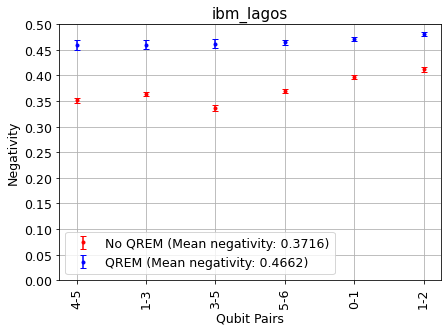

In [30]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_perth

In [13]:
backend = provider.get_backend('ibm_perth')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_perth (7 qubits)
Job 1 ID: 62e086025923b654835f3fbe
Job 2 ID: 62e086095923b634015f3fbf


In [31]:
time0 = time()
backend = provider.get_backend('ibm_perth')
job1 = backend.retrieve_job('62e086025923b654835f3fbe')
job2 = backend.retrieve_job('62e086095923b634015f3fbf')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 7.12 s


{'Mean negativity': 0.35278004758602916,
 'std': 0.014641472068305628,
 'Mean negativity (mit)': 0.48186634799616773,
 'std (mit)': 0.011011507581295953,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

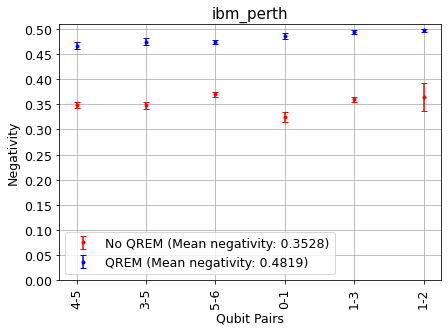

In [32]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_guadalupe

In [14]:
backend = provider.get_backend('ibmq_guadalupe')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_guadalupe (16 qubits)
Job 1 ID: 62e762a215d03377cc49967b
Job 2 ID: 62e762b922b5f5d8cd568004


In [33]:
time0 = time()
backend = provider.get_backend('ibmq_guadalupe')
job1 = backend.retrieve_job('62e762a215d03377cc49967b')
job2 = backend.retrieve_job('62e762b922b5f5d8cd568004')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 61.68 s


{'Mean negativity': 0.3354010593037919,
 'std': 0.02692384053199414,
 'Mean negativity (mit)': 0.44691403712085065,
 'std (mit)': 0.03172860760674204,
 'Connected N>5%': 16,
 'Connected N>50%': 16,
 'Connected N>75%': 2,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 16,
 'Connected N>50% (mit)': 16,
 'Connected N>75% (mit)': 16,
 'Connected N>90% (mit)': 11}

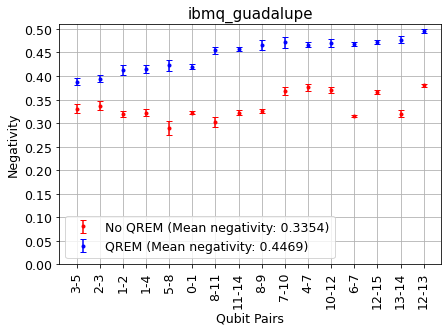

In [34]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_toronto

In [5]:
backend = provider.get_backend('ibmq_toronto')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_toronto (27 qubits)
Job 1 ID: 639fb9143c2e3c278da53a64
Job 2 ID: 639fb926cde4212813b156c1


In [7]:
time0 = time()
backend = provider.get_backend('ibmq_toronto')
job1 = backend.retrieve_job('639fb9143c2e3c278da53a64')
job2 = backend.retrieve_job('639fb926cde4212813b156c1')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 105.74 s


{'Mean negativity': 0.24805556741151308,
 'std': 0.1273568018587573,
 'Mean negativity (mit)': 0.41554925108081825,
 'std (mit)': 0.06831876851693755,
 'Connected N>5%': 26,
 'Connected N>50%': 10,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 14,
 'Connected N>90% (mit)': 4}

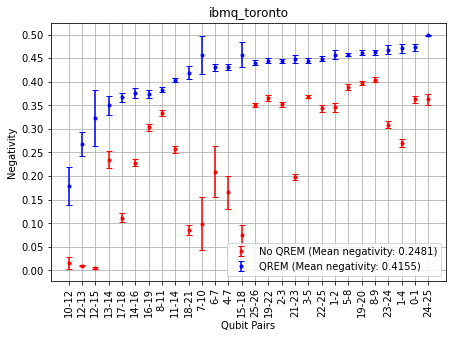

In [9]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities_thesis/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_geneva

In [11]:
backend = provider.get_backend('ibm_geneva')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_geneva (27 qubits)
Job 1 ID: 62e1d476fb9fa11a0da32153
Job 2 ID: 62e1d48bc12764f4277eb995


In [37]:
time0 = time()
backend = provider.get_backend('ibm_geneva')
job1 = backend.retrieve_job('62e1d476fb9fa11a0da32153')
job2 = backend.retrieve_job('62e1d48bc12764f4277eb995')

graphstate = GraphState(backend)
#rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
#rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
#time1 = time()
#print(f'Time elapsed: {time1 - time0:.2f} s')

{'Mean negativity': 0.22260218976939533,
 'std': 0.11771423130100589,
 'Mean negativity (mit)': 0.4034239943369352,
 'std (mit)': 0.07496613913150062,
 'Connected N>5%': 26,
 'Connected N>50%': 9,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 11,
 'Connected N>90% (mit)': 4}

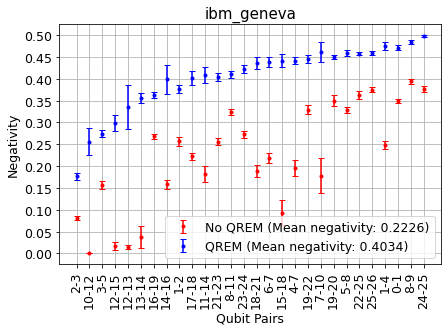

In [38]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_hanoi

In [13]:
backend = provider.get_backend('ibm_hanoi')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_hanoi (27 qubits)
Job 1 ID: 62debb30a7255f2ce80560da
Job 2 ID: 62debb76e52ec50930ce06a5


In [39]:
time0 = time()
backend = provider.get_backend('ibm_hanoi')
job1 = backend.retrieve_job('62debb30a7255f2ce80560da')
job2 = backend.retrieve_job('62debb76e52ec50930ce06a5')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 114.58 s


{'Mean negativity': 0.3299162483675386,
 'std': 0.06584429559717044,
 'Mean negativity (mit)': 0.46732187200937647,
 'std (mit)': 0.026076711098129188,
 'Connected N>5%': 27,
 'Connected N>50%': 26,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 27,
 'Connected N>90% (mit)': 17}

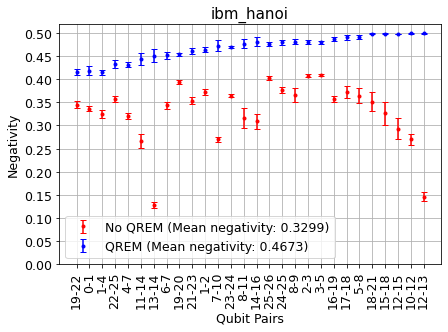

In [40]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_auckland

In [3]:
backend = provider.get_backend('ibm_auckland')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_auckland (27 qubits)
Job 1 ID: 62e0b39822b5f585165658b4
Job 2 ID: 62e0b3b2c2d497736fe36c1d


In [41]:
time0 = time()
backend = provider.get_backend('ibm_auckland')
job1 = backend.retrieve_job('62e0b39822b5f585165658b4')
job2 = backend.retrieve_job('62e0b3b2c2d497736fe36c1d')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 124.06 s


{'Mean negativity': 0.3724670214168043,
 'std': 0.06496949905202656,
 'Mean negativity (mit)': 0.4373778384081201,
 'std (mit)': 0.05971286131776886,
 'Connected N>5%': 27,
 'Connected N>50%': 26,
 'Connected N>75%': 13,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 26,
 'Connected N>90% (mit)': 13}

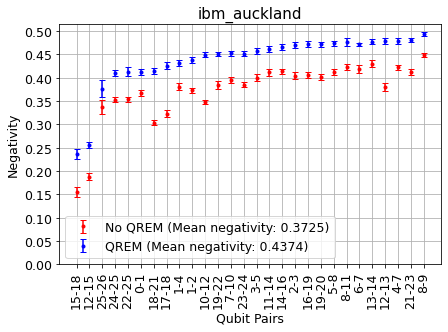

In [42]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibm_cairo

In [16]:
backend = provider.get_backend('ibm_cairo')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_cairo (27 qubits)
Job 1 ID: 62e006f6d5e93a5b6263784c
Job 2 ID: 62e007079ef051fa937697c1


In [43]:
time0 = time()
backend = provider.get_backend('ibm_cairo')
job1 = backend.retrieve_job('62e006f6d5e93a5b6263784c')
job2 = backend.retrieve_job('62e007079ef051fa937697c1')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 93.28 s


{'Mean negativity': 0.3558325725154137,
 'std': 0.03876550679521127,
 'Mean negativity (mit)': 0.45504250120077694,
 'std (mit)': 0.02603492973030284,
 'Connected N>5%': 27,
 'Connected N>50%': 27,
 'Connected N>75%': 4,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 27,
 'Connected N>90% (mit)': 9}

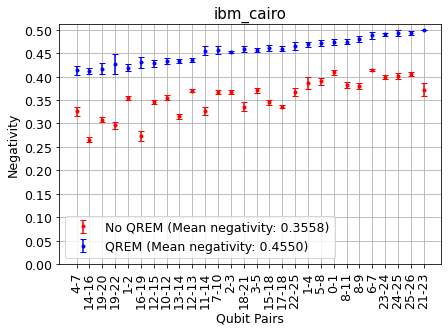

In [44]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_mumbai

In [17]:
backend = provider.get_backend('ibmq_mumbai')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_mumbai (27 qubits)
Job 1 ID: 62e007759ef05199917697d7
Job 2 ID: 62e0078aa7255f3449056904


In [45]:
time0 = time()
backend = provider.get_backend('ibmq_mumbai')
job1 = backend.retrieve_job('62e007759ef05199917697d7')
job2 = backend.retrieve_job('62e0078aa7255f3449056904')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 109.67 s


{'Mean negativity': 0.31547185263394145,
 'std': 0.08832531161488551,
 'Mean negativity (mit)': 0.4596723719385011,
 'std (mit)': 0.07822693979787759,
 'Connected N>5%': 27,
 'Connected N>50%': 23,
 'Connected N>75%': 4,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 27,
 'Connected N>90% (mit)': 23}

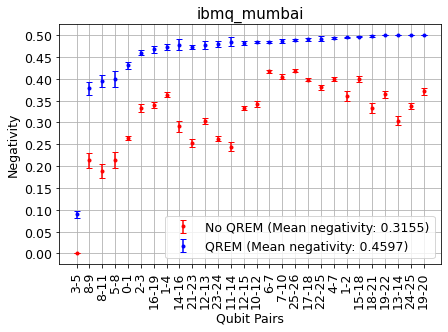

In [46]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

#### ibmq_montreal

In [4]:
backend = provider.get_backend('ibmq_montreal')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_montreal (27 qubits)
Job 1 ID: 639fb8893c2e3c1247a53a5c
Job 2 ID: 639fb8a3e9c45ae8f960d8c5


In [47]:
time0 = time()
backend = provider.get_backend('ibmq_montreal')
job1 = backend.retrieve_job('62e006677b5403911c2dccef')
job2 = backend.retrieve_job('62e0067d1813982307c6d2c3')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 122.65 s


{'Mean negativity': 0.24721293722670737,
 'std': 0.061555723387827124,
 'Mean negativity (mit)': 0.4240553438431984,
 'std (mit)': 0.05454631863306708,
 'Connected N>5%': 27,
 'Connected N>50%': 8,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 24,
 'Connected N>90% (mit)': 8}

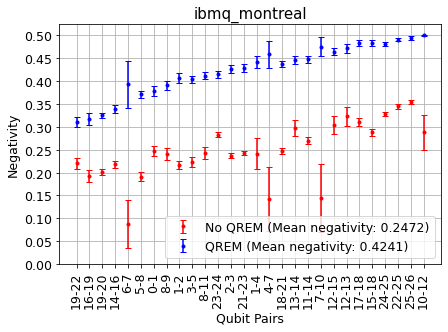

In [48]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

Qubit 7 had an anomously high readout error 3.265e-1 (mean 4.129e-2)

#### ibmq_kolkata

In [ ]:
backend = provider.get_backend('ibmq_kolkata')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

In [49]:
time0 = time()
backend = provider.get_backend('ibmq_kolkata')
job1 = backend.retrieve_job('62e0b33b5593a82bd1192732')
job2 = backend.retrieve_job('62e0b3558fc097738f0a8655')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 116.11 s


{'Mean negativity': 0.3332983963744673,
 'std': 0.11882553838988134,
 'Mean negativity (mit)': 0.40714102791650403,
 'std (mit)': 0.1344759561379048,
 'Connected N>5%': 27,
 'Connected N>50%': 24,
 'Connected N>75%': 9,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 25,
 'Connected N>75% (mit)': 22,
 'Connected N>90% (mit)': 11}

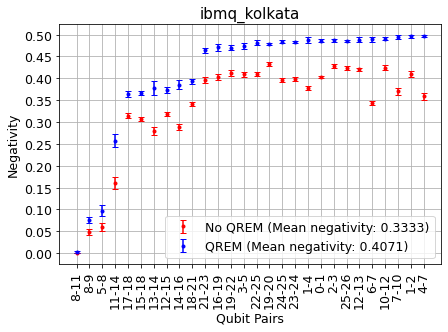

In [50]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

get_negativity_info(n_list, nmit_list)

In [28]:
import random
rand_labels = random.sample(range(0,10),10)
print(rand_labels)
a = [0,0]
b = [[1,1], [2,2], [5,5]]
for label in b:
    a[0] ^= label[0]
    a[1] ^= label[1]
    print(a)

from scipy.sparse import lil_matrix
c = lil_matrix((1,100))
c[0,2] = 2
c[0,5] = 1
print(c)

[5, 2, 0, 6, 8, 3, 9, 7, 4, 1]
[1, 1]
[3, 3]
[6, 6]
  (0, 2)	2.0
  (0, 5)	1.0


#### ibm_sherbrooke

In [2]:
from qiskit import execute, transpile
#backend = provider.get_backend('ibm_sherbrooke')
graphstate = GraphState(backend, qubits_to_connect = list(range(127)))
print(graphstate.qubits_to_connect)
#graphstate.gen_qst_circuits()

#circ_list = []
#for batch in graphstate.qst_circuits.values():
#    for circuit in batch.values():
#        circ_list.append(circuit)

#circ_list_multi = []
#for i in range(4):
#    for circ in circ_list:
#        name_ext = circ.name + f'-{i}'
#        circ_list_multi.append(circ.copy(name_ext))
#circ_list = circ_list_multi

#qrem_circuits = graphstate.gen_qrem_circuits()
#circ_list.extend(qrem_circuits)

#circ_list_transpiled = transpile(circ_list, backend = graphstate.backend)
#job = graphstate.backend.run(circ_list_transpiled, shots=shots)
#job = execute(circ_list[0], backend=graphstate.backend, shots=8192)
#for batch_circs in graphstate.qst_circuits.values():
#    for circ in batch_circs.values():
#        circ_new = transpile(circ, backend=backend)
#        print(circ_new.depth())
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True, execution_mode='execute')
#job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
print("Job 1 ID:", job1.job_id())
print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
#print("Job 2 ID:", job2.job_id())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
Job 1 ID: ci64s4gkbvp2ovrfinv0
Device: ibm_sherbrooke (127 qubits)


In [ ]:
time0 = time()
#backend = provider.get_backend('ibm_washington')
#job1 = backend.retrieve_job('630bf9359877ca68932a4cc7')
#job2 = backend.retrieve_job('630bf9d56d08101c02db5117')
#job1 = backend.retrieve_job('62f9b8033eae6d60a8d3b1ce')
#job2 = backend.retrieve_job('62f9b888d7bba196db87a916')
#job1 = backend.retrieve_job('62e7633bac90f75e39c85ceb')
#job2 = backend.retrieve_job('62e763a015d033aaad49968a')
#job1 = backend.retrieve_job('639fbac27f42d2d5e0d34ed0')
#job2 = backend.retrieve_job('639fbb25fbeeb32111907838')
#job1 = provider.backend.retrieve_job('chs2jqii3durlgpguprg') #washington (ibm provider/ execute) (too long/failed)
#job1 = provider.backend.retrieve_job('chs6mkjgsimdkukf09j0') #washington (ibmq provider/ execute) (failed)
job1 = provider.backend.retrieve_job('chs6o0grecnk2p3ab8eg') #sherbrooke (ibmq provider/ execute)
#job1 = provider.backend.retrieve_job('chs6q5jgsimdkukf3vig') #sherbrooke (ibm provider/ execute) (failed)
#job1 = provider.backend.retrieve_job('chs87jii3durlgpmacn0') #sherbrooke (ibm provider/ execute) (retry, failed)
#job1 = provider.backend.retrieve_job('chs9r81vrup8980affog') #washington (ibm provider/ transpiled/run) (failed)
job1 = provider.backend.retrieve_job('chu0jfr91dmpcnh2f0ng') #brisbane (ibm provider/ execute)
job1 = provider.backend.retrieve_job('chu5i6ii3durlgrcmjk0') #sherbrooke (ibm provider/ execute) (1 rep retry)
#job1 = provider.backend.retrieve_job('churqc9oq2qn3r33b3mg') #sherbrooke (ibm provider/ transpiled) (4 rep retry) (failed)
#job1 = service.job('chvb4o8pd9tm50runjvg') #sherbrooke (runtime backend/ sampler) (failed)
job1 = provider.backend.retrieve_job('chvic6mnfq8rvo0sum5g') #cairo (ibm provider/ execute/ Fidel's original code)
job1 = provider.backend.retrieve_job('chvicoqpvii3c2q43lng') #cairo (ibm provider/ execute) 
job1 = provider.backend.retrieve_job('chvih30pd9tm50s4bmn0') #brisbane (ibm provider/ execute/Fidel's original code) 
#job1 = provider.backend.retrieve_job('ci3t68tejm3lf1ce8vhg') #sherbrooke (ibm provider/ transpiled) (failed) 
job1 = provider.backend.retrieve_job('ci64s4gkbvp2ovrfinv0') #sherbrooke (ibm provider/ execute) 
print(len(job1.result().results))
graphstate = GraphState(backend, qubits_to_connect=list(range(127)))
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
#rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

{'Mean negativity': 0.2593386983008223,
 'std': 0.11368966466354032,
 'Mean negativity (mit)': 0.38895069844323854,
 'std (mit)': 0.10618796305368298,
 'Connected N>5%': 120,
 'Connected N>50%': 52,
 'Connected N>75%': 6,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 127,
 'Connected N>50% (mit)': 112,
 'Connected N>75% (mit)': 59,
 'Connected N>90% (mit)': 18}

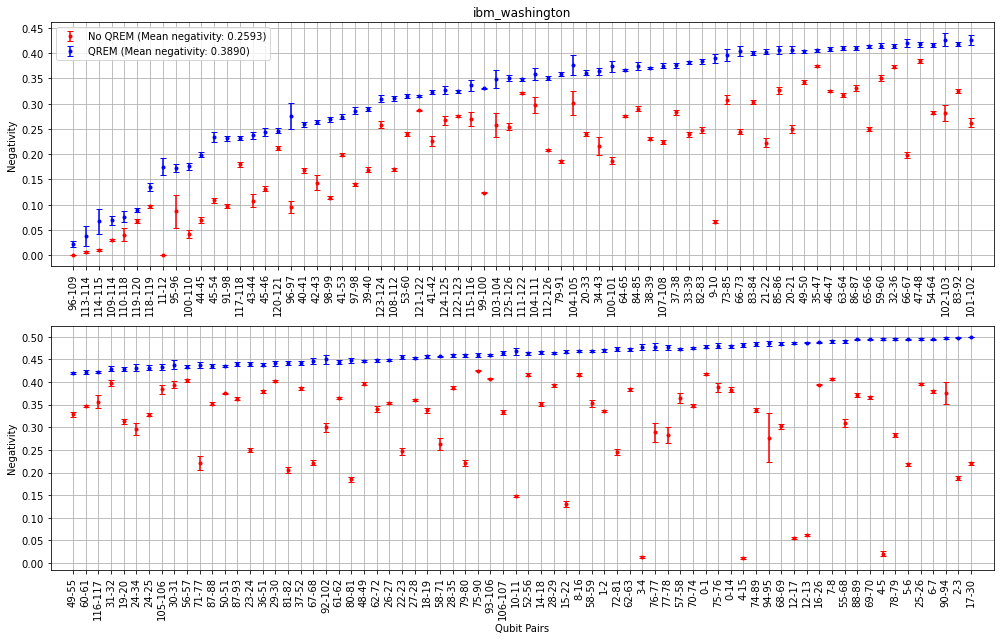

In [4]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

############# ONLY FINDS NEGATIVITY OF THE DESIRED EDGES
n_list_new = []
for i in range(len(n_list)):
    reduced_n_dict = {}
    for edge, n in n_list[i].items():
        if (edge[0] in [0,1,4,7,10,12,15,18,21,23]) and (edge[1] in [0,1,4,7,10,12,15,18,21,23]):
            reduced_n_dict[edge] = n
    n_list_new.append(reduced_n_dict)

nmit_list_new = []
for i in range(len(nmit_list)):
    reduced_n_dict = {}
    for edge, n in nmit_list[i].items():
        if (edge[0] in [0,1,4,7,10,12,15,18,21,23]) and (edge[1] in [0,1,4,7,10,12,15,18,21,23]):
            reduced_n_dict[edge] = n
    nmit_list_new.append(reduced_n_dict)
#fig = plot_negativities_multi(backend, n_list, nmit_list, figsize=(21, 7))
#fig.tight_layout()
#fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 9))

#edges = n_list[0].keys()
#n_mean, n_std = calc_n_mean(n_list)
edges = n_list_new[0].keys()
n_mean, n_std = calc_n_mean(n_list_new)

# Convert into array for plotting
X = np.array([f'{edge[0]}-{edge[1]}' for edge in edges])
Y0 = np.fromiter(n_mean.values(), float)
Y0err = np.fromiter(n_std.values(), float)

# If mitigated results are included
#nmit_mean, nmit_std = calc_n_mean(nmit_list)
nmit_mean, nmit_std = calc_n_mean(nmit_list_new)

Y1 = np.fromiter(nmit_mean.values(), float)
Y1err = np.fromiter(nmit_std.values(), float)
# Order in increasing minimum negativity (QREM)
Y1min = Y1 - Y1err
idx = Y1min.argsort()
Y1 = Y1[idx]
Y1err = Y1err[idx]

X = X[idx]
Y0 = Y0[idx]
Y0err = Y0err[idx]

hp = int(len(X)/2)

ax1.errorbar(X[:hp], Y0[:hp], yerr=Y0err[:hp], capsize=3, fmt='.', c='r', 
            label=f'No QREM (Mean negativity: {np.mean(Y0):.4f})')

ax1.errorbar(X[:hp], Y1[:hp], yerr=Y1err[:hp], capsize=3, fmt='.', c='b', 
            label=f'QREM (Mean negativity: {np.mean(Y1):.4f})')

ax2.errorbar(X[hp:], Y0[hp:], yerr=Y0err[hp:], capsize=3, fmt='.', c='r', 
            label=f'No QREM (Mean negativity: {np.mean(Y0):.4f})')

ax2.errorbar(X[hp:], Y1[hp:], yerr=Y1err[hp:], capsize=3, fmt='.', c='b', 
            label=f'QREM (Mean negativity: {np.mean(Y1):.4f})')

for ax in (ax1, ax2):
    ax.set_yticks(np.arange(0, 0.55, 0.05))
    ax.tick_params(axis='x', labelrotation=90)
    ax.grid()
    ax.set_ylabel("Negativity")
    ax.margins(0.025, 0.05)
    
ax1.legend()
ax2.set_xlabel("Qubit Pairs")
ax1.set_title(backend.name())
fig.set_tight_layout(True)

#fig.savefig('output/negativities/ibm_washington_negativities', dpi=300)

#get_negativity_info(n_list, nmit_list)
get_negativity_info(n_list_new, nmit_list_new)

#### Negativity Map

In [5]:
import matplotlib as mpl
from qiskit.visualization import plot_gate_map, plot_coupling_map
from qubit_coords import qubit_coords127

plt.rc('font', size=13)

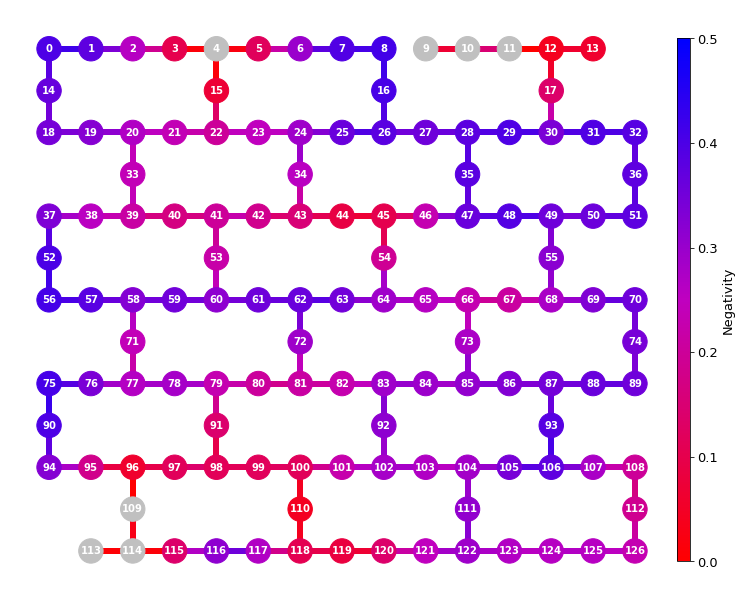

In [6]:
nqubits = 127
#n_dict = nmit_mean
n_dict = n_mean

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['tab:red', 'tab:purple', 'tab:blue'])

edges = filter_edges(n_dict, threshold=0.025)
G = nx.Graph()
G.add_edges_from(edges)
unconnected = list(set(range(127)) - list(nx.connected_components(G))[0])

qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []

for key, values in n_dict.items():
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*values), keep_alpha=True))
    qubit_n[key[0]] += values
    qubit_n[key[1]] += values
    
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))

fig = plot_coupling_map(nqubits, qubit_coords127, edge_list, line_color=line_color, qubit_color=qubit_color,
                        line_width=6, figsize=(12,12))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
fig.savefig('output/ghznmap127.png', dpi=400)

fig

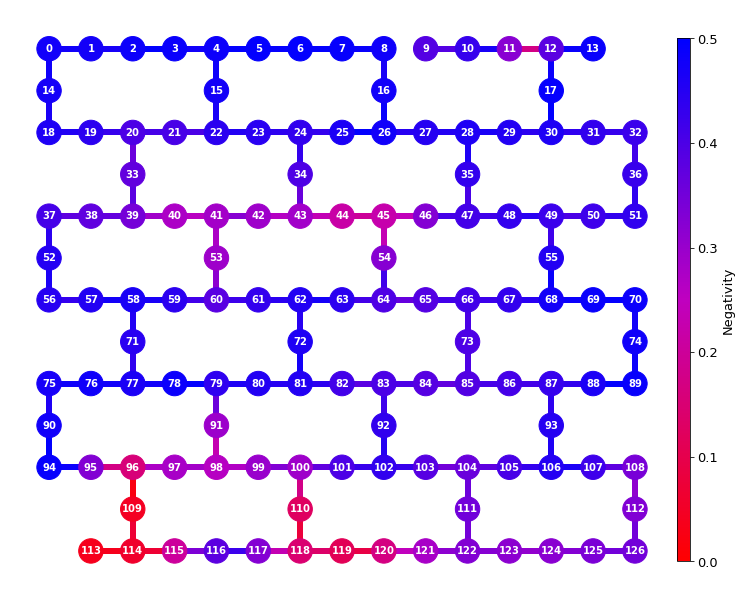

In [7]:
nqubits = 127
n_dict = nmit_mean
#n_dict = n_mean

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['tab:red', 'tab:purple', 'tab:blue'])

edges = filter_edges(n_dict, threshold=0.025)
G = nx.Graph()
G.add_edges_from(edges)
unconnected = list(set(range(127)) - list(nx.connected_components(G))[0])

qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []

for key, values in n_dict.items():
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*values), keep_alpha=True))
    qubit_n[key[0]] += values
    qubit_n[key[1]] += values
    
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))

fig = plot_coupling_map(nqubits, qubit_coords127, edge_list, line_color=line_color, qubit_color=qubit_color,
                        line_width=6, figsize=(12,12))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
fig.savefig('output/ghznmitmap127.png', dpi=400)

fig

## Negativity Correlations

In [10]:
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr


n_mean = calc_n_mean(n_list)
nmit_mean = calc_n_mean(nmit_list) #find mean and standard deviations of negativities i.e. n_mean is {(0,1):0.4,(1,2):0.3...}
properties = job1.properties()
adj_edges = graphstate.adj_edges

n_meanf = {}
nmit_meanf = {}
edges = n_mean[0].keys()
for edge in edges:
    err = properties.gate_error('ecr', edge) # obtain corresponding CNOT error for this pair of qubits
    if err < 0.1:
        n_meanf[edge] = n_mean[0][edge] #filter the n_mean by discarding those edges with CNOT error < 0.1
        nmit_meanf[edge] = nmit_mean[0][edge]

#fig1a = plot_cxerr_corr(properties, adj_edges, n_meanf, inc_adj=False)
X, Y0 = plot_cxerr_corr(properties, adj_edges, n_meanf, inc_adj=False) # Plot negativity vs CNOT errors
#fig2a = plot_cxerr_corr(properties, adj_edges, nmit_meanf, inc_adj=False)
X, Y1 = plot_cxerr_corr(properties, adj_edges, nmit_meanf, inc_adj=False)
    
c0, m0 = polyfit(X, Y0, 1) #obtain Linear regression parameters c0 = y-intercept, m0 = gradient for data points CX error, negativities
c1, m1 = polyfit(X, Y1, 1)
Xfit = np.linspace(min(X), max(X), 100) # fitted linear line X variables

corr0, _ = pearsonr(X, Y0) #obtain linear correlation between CNOT erros and negativities
corr1, _ = pearsonr(X, Y1)

BackendPropertyError: 'Could not find the desired property for ecr'

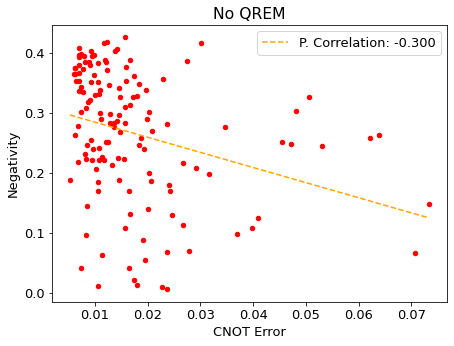

In [9]:
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(6.5, 5))
ax.scatter(X, Y0, color='red', s=20) #Plot the CNOT errors vs negativities
ax.plot(Xfit, m0*Xfit+c0, ls='--', color='orange', label=f'P. Correlation: {corr0:.3f}') # add line of best fit

ax.set_title('No QREM')

ax.set_ylabel('Negativity')
ax.set_xlabel('CNOT Error')

ax.legend(loc=1)

fig.set_tight_layout(True)
fig.savefig('output/negativitycorrelation1', dpi=300)

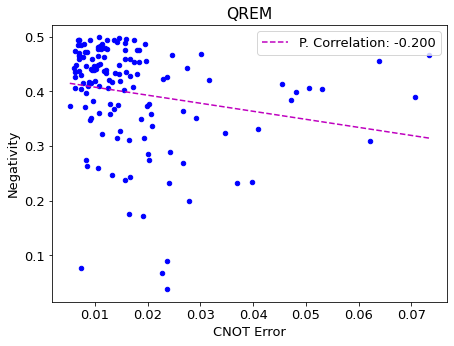

In [12]:
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(6.5, 5))
ax.scatter(X, Y1, color='b', s=20)
ax.plot(Xfit, m1*Xfit+c1, ls='--', color='m', label=f'P. Correlation: {corr1:.3f}')

ax.set_title('QREM')

ax.set_ylabel('Negativity')
ax.set_xlabel('CNOT Error')

ax.legend(loc=1)

fig.set_tight_layout(True)
fig.savefig('output/negativitycorrelation2', dpi=300)

NameError: name 'Xfit' is not defined

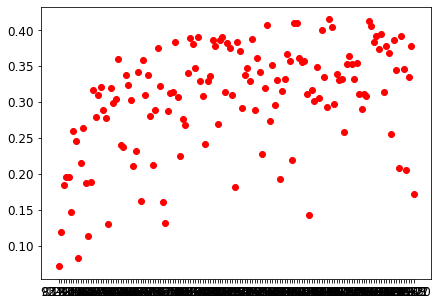

In [5]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X, Y0, marker='o', color='r')
ax.plot(Xfit, m0*Xfit+c0, ls='--', label=f'P. Correlation (No QREM): {corr0:.3f}')
ax.scatter(X, Y1, marker='^', color='b')
ax.plot(Xfit, m1*Xfit+c1, ls='--', label=f'P. Correlation (QREM): {corr1:.3f}')

ax.set_ylabel('Negativity')
ax.set_xlabel('CNOT Error')

ax.legend()
#ax.legend(loc=1)

fig.set_tight_layout(True)
#fig.savefig('output/negativitycorrelation', dpi=300)

In [5]:
backend = provider.get_backend('ibm_sherbrooke')
graphstate = GraphState(backend, qubits_to_connect=list(range(127)))
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
#job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
#print("Job 2 ID:", job2.job_id())

Device: ibm_sherbrooke (127 qubits)
Job 1 ID: chrfbibgsimdkujkmhmg


In [3]:
time0 = time()
backend = provider.get_backend('ibm_sherbrooke')

#job1 = backend.retrieve_job('63a14bf5fd03a43b63215045')
job1 = backend.retrieve_job('chrfbibgsimdkujkmhmg')
job2 = backend.retrieve_job('63a14c86fd1c840a5beba753')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 466.67 s


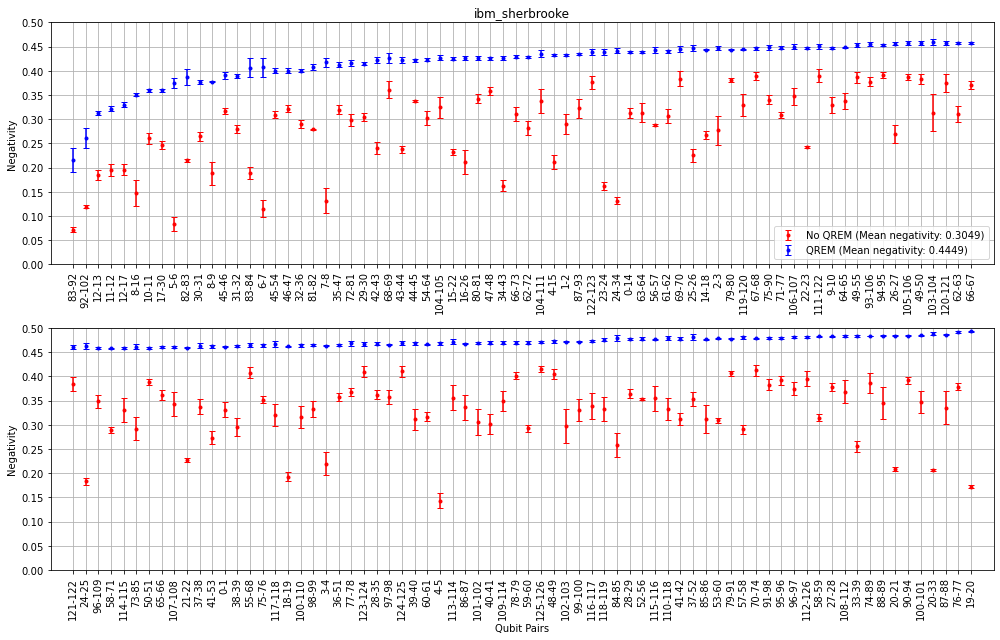

In [4]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

#fig = plot_negativities_multi(backend, n_list, nmit_list, figsize=(21, 7))
#fig.tight_layout()
#fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 9))

edges = n_list[0].keys()
n_mean, n_std = calc_n_mean(n_list)

# Convert into array for plotting
X = np.array([f'{edge[0]}-{edge[1]}' for edge in edges])
Y0 = np.fromiter(n_mean.values(), float)
Y0err = np.fromiter(n_std.values(), float)

# If mitigated results are included
nmit_mean, nmit_std = calc_n_mean(nmit_list)

Y1 = np.fromiter(nmit_mean.values(), float)
Y1err = np.fromiter(nmit_std.values(), float)
# Order in increasing minimum negativity (QREM)
Y1min = Y1 - Y1err
idx = Y1min.argsort()
Y1 = Y1[idx]
Y1err = Y1err[idx]

X = X[idx]
Y0 = Y0[idx]
Y0err = Y0err[idx]

hp = int(len(X)/2)

ax1.errorbar(X[:hp], Y0[:hp], yerr=Y0err[:hp], capsize=3, fmt='.', c='r', 
            label=f'No QREM (Mean negativity: {np.mean(Y0):.4f})')

ax1.errorbar(X[:hp], Y1[:hp], yerr=Y1err[:hp], capsize=3, fmt='.', c='b', 
            label=f'QREM (Mean negativity: {np.mean(Y1):.4f})')

ax2.errorbar(X[hp:], Y0[hp:], yerr=Y0err[hp:], capsize=3, fmt='.', c='r', 
            label=f'No QREM (Mean negativity: {np.mean(Y0):.4f})')

ax2.errorbar(X[hp:], Y1[hp:], yerr=Y1err[hp:], capsize=3, fmt='.', c='b', 
            label=f'QREM (Mean negativity: {np.mean(Y1):.4f})')

for ax in (ax1, ax2):
    ax.set_yticks(np.arange(0, 0.55, 0.05))
    ax.tick_params(axis='x', labelrotation=90)
    ax.grid()
    ax.set_ylabel("Negativity")
    ax.margins(0.025, 0.05)
    
ax1.legend()
ax2.set_xlabel("Qubit Pairs")
ax1.set_title(backend.name())

ax1.set_ylim([0,0.5])
ax2.set_ylim([0,0.5])
fig.set_tight_layout(True)

fig.savefig('output/negativities_old/ibm_sherbrooke_negativities', dpi=300)

In [17]:
import matplotlib as mpl
from qiskit.visualization import plot_gate_map, plot_coupling_map
from qubit_coords import qubit_coords127

plt.rc('font', size=13)

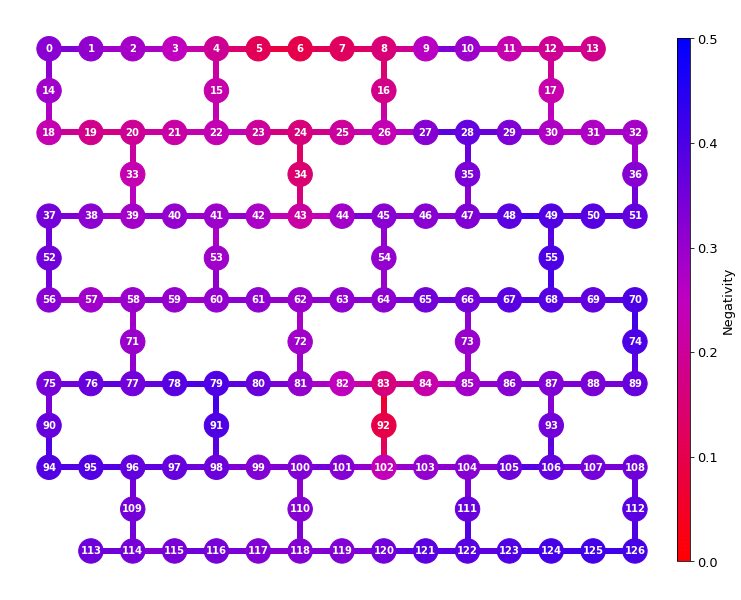

In [18]:
nqubits = 127
#n_dict = nmit_mean
n_dict = n_mean

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['tab:red', 'tab:purple', 'tab:blue'])

edges = filter_edges(n_dict, threshold=0.025)
G = nx.Graph()
G.add_edges_from(edges)
unconnected = list(set(range(127)) - list(nx.connected_components(G))[0])

qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []

for key, values in n_dict.items():
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*values), keep_alpha=True))
    qubit_n[key[0]] += values
    qubit_n[key[1]] += values
    
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))

fig = plot_coupling_map(nqubits, qubit_coords127, edge_list, line_color=line_color, qubit_color=qubit_color,
                        line_width=6, figsize=(12,12))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
fig.savefig('output/GSmap127sherbrooke.png', dpi=400)

fig

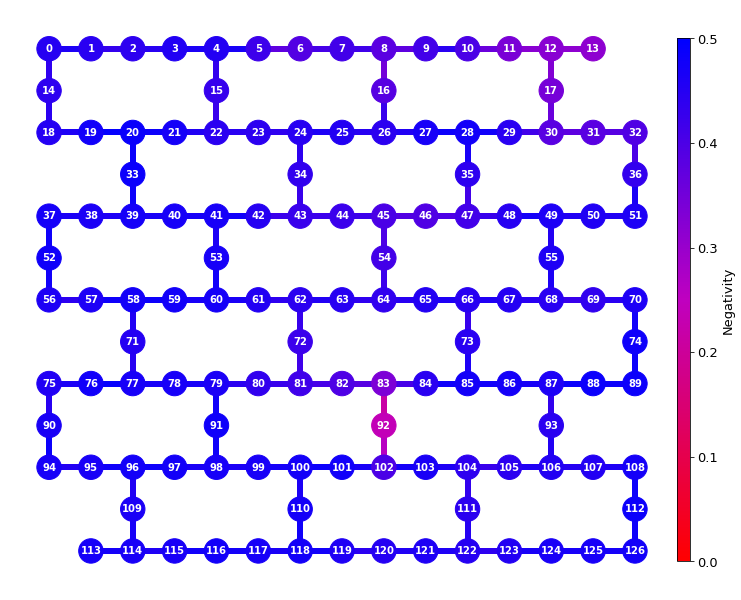

In [19]:
nqubits = 127
n_dict = nmit_mean
#n_dict = n_mean

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['tab:red', 'tab:purple', 'tab:blue'])

edges = filter_edges(n_dict, threshold=0.025)
G = nx.Graph()
G.add_edges_from(edges)
unconnected = list(set(range(127)) - list(nx.connected_components(G))[0])

qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []

for key, values in n_dict.items():
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*values), keep_alpha=True))
    qubit_n[key[0]] += values
    qubit_n[key[1]] += values
    
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))

fig = plot_coupling_map(nqubits, qubit_coords127, edge_list, line_color=line_color, qubit_color=qubit_color,
                        line_width=6, figsize=(12,12))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
fig.savefig('output/GSmitmap127sherbrooke.png', dpi=400)

fig

In [ ]:
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr


n_mean = calc_n_mean(n_list)
nmit_mean = calc_n_mean(nmit_list) #find mean and standard deviations of negativities i.e. n_mean is {(0,1):0.4,(1,2):0.3...}
properties = job1.properties()
adj_edges = graphstate.adj_edges

n_meanf = {}
nmit_meanf = {}
edges = n_mean[0].keys()
for edge in edges:
    err = properties.gate_error('cx', edge) # obtain corresponding CNOT error for this pair of qubits
    if err < 0.1:
        n_meanf[edge] = n_mean[0][edge] #filter the n_mean by discarding those edges with CNOT error < 0.1
        nmit_meanf[edge] = nmit_mean[0][edge]

#fig1a = plot_cxerr_corr(properties, adj_edges, n_meanf, inc_adj=False)
X, Y0 = plot_cxerr_corr(properties, adj_edges, n_meanf, inc_adj=False) # Plot negativity vs CNOT errors
#fig2a = plot_cxerr_corr(properties, adj_edges, nmit_meanf, inc_adj=False)
X, Y1 = plot_cxerr_corr(properties, adj_edges, nmit_meanf, inc_adj=False)

c0, m0 = polyfit(X, Y0, 1) #obtain Linear regression parameters c0 = y-intercept, m0 = gradient for data points CX error, negativities
c1, m1 = polyfit(X, Y1, 1)
Xfit = np.linspace(min(X), max(X), 100) # fitted linear line X variables

corr0, _ = pearsonr(X, Y0) #obtain linear correlation between CNOT erros and negativities
corr1, _ = pearsonr(X, Y1)

ibm_seattle

In [2]:
#backend = provider.get_backend('ibm_seattle')
graphstate = GraphState(backend, qubits_to_connect = list(range(len(backend.properties().qubits))))
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
#job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
#print("Job 2 ID:", job2.job_id())

Device: <IBMBackend('ibm_seattle')> (433 qubits)
Job 1 ID: chdehnrnn76jgg00tn1g


In [3]:
print(backend.properties().backend_name)

ibm_seattle


In [ ]:
time0 = time()
backend = provider.get_backend('ibm_sherbrooke')

job1 = backend.retrieve_job('63a14bf5fd03a43b63215045')
job2 = backend.retrieve_job('63a14c86fd1c840a5beba753')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

In [ ]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

#fig = plot_negativities_multi(backend, n_list, nmit_list, figsize=(21, 7))
#fig.tight_layout()
#fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 9))

edges = n_list[0].keys()
n_mean, n_std = calc_n_mean(n_list)

# Convert into array for plotting
X = np.array([f'{edge[0]}-{edge[1]}' for edge in edges])
Y0 = np.fromiter(n_mean.values(), float)
Y0err = np.fromiter(n_std.values(), float)

# If mitigated results are included
nmit_mean, nmit_std = calc_n_mean(nmit_list)

Y1 = np.fromiter(nmit_mean.values(), float)
Y1err = np.fromiter(nmit_std.values(), float)
# Order in increasing minimum negativity (QREM)
Y1min = Y1 - Y1err
idx = Y1min.argsort()
Y1 = Y1[idx]
Y1err = Y1err[idx]

X = X[idx]
Y0 = Y0[idx]
Y0err = Y0err[idx]

hp = int(len(X)/2)

ax1.errorbar(X[:hp], Y0[:hp], yerr=Y0err[:hp], capsize=3, fmt='.', c='r', 
            label=f'No QREM (Mean negativity: {np.mean(Y0):.4f})')

ax1.errorbar(X[:hp], Y1[:hp], yerr=Y1err[:hp], capsize=3, fmt='.', c='b', 
            label=f'QREM (Mean negativity: {np.mean(Y1):.4f})')

ax2.errorbar(X[hp:], Y0[hp:], yerr=Y0err[hp:], capsize=3, fmt='.', c='r', 
            label=f'No QREM (Mean negativity: {np.mean(Y0):.4f})')

ax2.errorbar(X[hp:], Y1[hp:], yerr=Y1err[hp:], capsize=3, fmt='.', c='b', 
            label=f'QREM (Mean negativity: {np.mean(Y1):.4f})')

for ax in (ax1, ax2):
    ax.set_yticks(np.arange(0, 0.55, 0.05))
    ax.tick_params(axis='x', labelrotation=90)
    ax.grid()
    ax.set_ylabel("Negativity")
    ax.margins(0.025, 0.05)
    
ax1.legend()
ax2.set_xlabel("Qubit Pairs")
ax1.set_title(backend.name())

ax1.set_ylim([0,0.5])
ax2.set_ylim([0,0.5])
fig.set_tight_layout(True)

fig.savefig('output/negativities_old/ibm_sherbrooke_negativities', dpi=300)

In [ ]:
import matplotlib as mpl
from qiskit.visualization import plot_gate_map, plot_coupling_map
from qubit_coords import qubit_coords127

plt.rc('font', size=13)

In [ ]:
nqubits = 127
#n_dict = nmit_mean
n_dict = n_mean

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['tab:red', 'tab:purple', 'tab:blue'])

edges = filter_edges(n_dict, threshold=0.025)
G = nx.Graph()
G.add_edges_from(edges)
unconnected = list(set(range(127)) - list(nx.connected_components(G))[0])

qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []

for key, values in n_dict.items():
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*values), keep_alpha=True))
    qubit_n[key[0]] += values
    qubit_n[key[1]] += values
    
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))

fig = plot_coupling_map(nqubits, qubit_coords127, edge_list, line_color=line_color, qubit_color=qubit_color,
                        line_width=6, figsize=(12,12))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
fig.savefig('output/GSmap127sherbrooke.png', dpi=400)

fig